# NER Disease Name Recognition using NCBI-disease dataset

### Imports

In [1]:
import re
import string
import torch
import numpy as np
import pandas as pd
import seqeval
import tensorflow as tf
from seqeval.metrics import accuracy_score
from nltk.corpus import stopwords
from datasets import load_dataset
from transformers import BertTokenizer, AdamW
from transformers import BertForTokenClassification, DistilBertTokenizer, TFDistilBertModel, DistilBertForTokenClassification, DistilBertConfig, DistilBertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import CrossEntropyLoss 
from seqeval.metrics  import accuracy_score
from torchmetrics import AUROC
from sklearn.metrics import classification_report

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import NanoBERT.nanobert.modeling as nano

### Load Data

In [4]:
train_set = load_dataset("ncbi_disease", revision="main", split='train')
val_set = load_dataset("ncbi_disease", revision="main", split='validation')
test_set = load_dataset("ncbi_disease", revision="main", split='test')

Found cached dataset ncbi_disease (/Users/vidyabulusu/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)
Found cached dataset ncbi_disease (/Users/vidyabulusu/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)
Found cached dataset ncbi_disease (/Users/vidyabulusu/.cache/huggingface/datasets/ncbi_disease/ncbi_disease/1.0.0/92314c7992b0b8a5ea2ad101be33f365b684a2cc011e0ffa29c691e6d32b2d03)


In [5]:
data = train_set.to_pandas()
data

,id,tokens,ner_tags
0,0,"[Identification, of, APC2, ,, a, homologue, of...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]"
1,1,"[The, adenomatous, polyposis, coli, (, APC, ),...","[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[Complex, formation, induces, the, rapid, degr...","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,"[In, colon, carcinoma, cells, ,, loss, of, APC...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[Here, ,, we, report, the, identification, and...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
5428,5428,"[Here, ,, we, show, that, retroviral, transfer...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5429,5429,"[Mutant, BRCA1, has, no, effect, on, growth, o...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, ..."
5430,5430,"[Development, of, MCF, -, 7, tumours, in, nude...","[0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5431,5431,"[Most, importantly, ,, among, mice, with, esta...","[0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, ..."


This dataset has already been cleaned and tokenized. Hence, there is no need to do preprocessing. Also, the length of the ner_tags match the length of the corresponding tokens. Hence, cleaning and removing stop-words / punctuation will result in erroneous metrics.

In [6]:
data.tokens[10], data.ner_tags[10], len(data.tokens[10]), len(data.ner_tags[10]) 

(array(['A', 'common', 'MSH2', 'mutation', 'in', 'English', 'and', 'North',
        'American', 'HNPCC', 'families', ':', 'origin', ',', 'phenotypic',
        'expression', ',', 'and', 'sex', 'specific', 'differences', 'in',
        'colorectal', 'cancer', '.'], dtype=object),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 2, 0]),
 25,
 25)

Delete rows with empty tags

In [7]:
data = data[data.ner_tags.str.len() > 0]
data

,id,tokens,ner_tags
0,0,"[Identification, of, APC2, ,, a, homologue, of...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]"
1,1,"[The, adenomatous, polyposis, coli, (, APC, ),...","[0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[Complex, formation, induces, the, rapid, degr...","[0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,3,"[In, colon, carcinoma, cells, ,, loss, of, APC...","[0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[Here, ,, we, report, the, identification, and...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...
5427,5427,"[Inherited, mutations, in, BRCA1, predispose, ...","[0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, ..."
5428,5428,"[Here, ,, we, show, that, retroviral, transfer...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5429,5429,"[Mutant, BRCA1, has, no, effect, on, growth, o...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 1, 2, 0, ..."
5430,5430,"[Development, of, MCF, -, 7, tumours, in, nude...","[0, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
val_data = val_set.to_pandas()
val_data = val_data[val_data.ner_tags.str.len() > 0]

test_data = test_set.to_pandas()
test_data = test_data[test_data.ner_tags.str.len() > 0]

Setting the max_length by counting the number of tokens in the longest sequence of the dataset

In [9]:
data["num_tokens"] = data.tokens.str.len()

/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/3897620915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["num_tokens"] = data.tokens.str.len()


In [10]:
MAX_LEN = data["num_tokens"].max()
BATCH_SIZE = 16

### Tokenizer
Using bio-distilbert tokenizer trained on Clinical Data

In [11]:
tokenizer = DistilBertTokenizerFast.from_pretrained('nlpie/bio-distilbert-uncased')

In [12]:
text_tokenized = tokenizer(list(data.tokens.apply(lambda x: " ".join(x)).to_numpy()), 
                           max_length=MAX_LEN, 
                           padding='max_length', 
                           truncation=True,
                           return_tensors='pt')

In [13]:
val_text_tokenized = tokenizer(list(val_data.tokens.apply(lambda x: " ".join(x)).to_numpy()), 
                               max_length=MAX_LEN, padding='max_length', 
                               truncation=True, return_tensors='pt')

test_text_tokenized = tokenizer(list(test_data.tokens.apply(lambda x: " ".join(x)).to_numpy()), 
                                max_length=MAX_LEN, padding='max_length',
                                truncation=True, return_tensors='pt')

The dataset has a tag '1' identifying the first occurence of the disease-related token and tag '2' for subsequent disease-related tokens. For our project, we will convert all disease-related tokens to have tags as '1'.

In [14]:
def update_target_tags(tag):
    tag = np.array(tag)
    tag[tag == 2] = 1
    return np.pad(tag, pad_width=(0, MAX_LEN-len(tag))) # the length of each token list has been padded to max_len, hence, tag list length has to match and has to be padded
    

update_target_tags([0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0])

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [15]:
train_tags = data.ner_tags.apply(update_target_tags)
val_tags = val_data.ner_tags.apply(update_target_tags)
test_tags = test_data.ner_tags.apply(update_target_tags)

The tokenizer returns extra tokens to identify the start and end of each sequence. Also, the tokenizer breaks down some words into subwords. This creates a mismatch between the tokens and their corresponding tags. We need to identify the extra tokens and tag them as '-100' (disregard them) and the subword tokens all get the same tag as their respective mapped word.

In [16]:
def tokenize_and_align_labels(token_lst, tags):
    tokenized_inputs = token_lst
    labels = []
    for i, label in enumerate(tags):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Label all subwords with the same tag
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = np.array(labels)
    return tokenized_inputs

We do not apply this to the test labels as we do not pass them to the model.

In [17]:
train_labels = tokenize_and_align_labels(text_tokenized, train_tags)["labels"]
val_labels = tokenize_and_align_labels(val_text_tokenized, val_tags)["labels"]
test_labels = tokenize_and_align_labels(test_text_tokenized, test_tags)["labels"]

### Create a custom NCBI Dataset for the dataloader

In [18]:
class NCBI_dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        self.size=len(self.labels)
       
    def __getitem__(self, idx):
        # return self.encodings["input_ids"[idx], self.labels[idx]
        input_ids = torch.tensor(self.encodings["input_ids"][idx]).squeeze()
        target_ids = torch.tensor(self.encodings["attention_mask"][idx]).squeeze()
        tags = torch.tensor(self.labels[idx]).squeeze()
        return input_ids,target_ids,tags
    
    def __len__(self):
        return self.size

In [21]:
train_dataset = NCBI_dataset(text_tokenized, train_labels)
val_dataset = NCBI_dataset(val_text_tokenized, val_labels)
test_dataset = NCBI_dataset(test_text_tokenized, test_labels)

### Dataloader

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# DistilBERT

Training and finetuning the pretrained DistilBertForTokenClassification model

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

distil_bert_model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased')
distil_bert_model.to(device)

# Optimizer
optim = AdamW(distil_bert_model.parameters(), lr=5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

In [35]:
%%time 

model = distil_bert_model
# Train the model
# Save the average loss after each epoch; these values are used to plot the loss.
train_loss_values, val_loss_values = [], []

for epoch in range(3):
    print('--------------------------------------------------------------------------')
    print(f'Epoch: {epoch}')
    
    # Set the model to train mode
    model.train()
    total_loss = 0
    total_val_loss = 0
    for batch in train_dataloader:
        optim.zero_grad()
        outputs = model(batch[0], attention_mask=batch[1], labels=batch[2])
        loss, scores = outputs[:2]
        loss.backward()
        total_loss += loss.item()
        # Clip the norm of the gradient to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optim.step()
    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store each loss value for plotting the learning curve afterwards
    train_loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on validation set
    # Set the model into evaluation mode
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    predictions , true_labels = [], []
    for batch in val_dataloader:
        # The model must not compute or save gradients, in order to save memory and speed up this step
        optim.zero_grad()
            # Forward pass, compute predictions
        outputs = model(batch[0],attention_mask=batch[1],labels=batch[2])
        val_loss = outputs.loss
        val_loss.backward()
        total_val_loss += val_loss.item()

        label_ids = batch[2].to(device).numpy()
        label_ids[label_ids == -100] = 0 # If the label == -100, we need to ignore it and not use it for loss/auroc computations
        predictions.extend(np.argmax(torch.sigmoid(outputs.logits).detach().numpy(),2))
        true_labels.extend(label_ids)

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optim.step()

    eval_loss = total_val_loss / len(val_dataloader)
    val_loss_values.append(eval_loss)
    print("Average Validation loss: {}".format(eval_loss))
    auroc = AUROC(task="binary")
    print("Validation AUROC: {}".format(auroc(torch.tensor(np.array(predictions)), torch.tensor(np.array(true_labels)))))
    print()

--------------------------------------------------------------------------
Epoch: 0


/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(self.encodings["input_ids"][idx]).squeeze()
/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.encodings["attention_mask"][idx]).squeeze()


Average train loss: 0.08906848286757903
Average Validation loss: 0.047052247016208956
Validation AUROC: 0.929693341255188

--------------------------------------------------------------------------
Epoch: 1
Average train loss: 0.029424380803795752
Average Validation loss: 0.01679077163912709
Validation AUROC: 0.9542677402496338

--------------------------------------------------------------------------
Epoch: 2
Average train loss: 0.013505682858864448
Average Validation loss: 0.006345769787128966
Validation AUROC: 0.9655998945236206

CPU times: user 1h 5min 27s, sys: 9min 3s, total: 1h 14min 31s
Wall time: 27min 58s


### Train and validation Loss curves

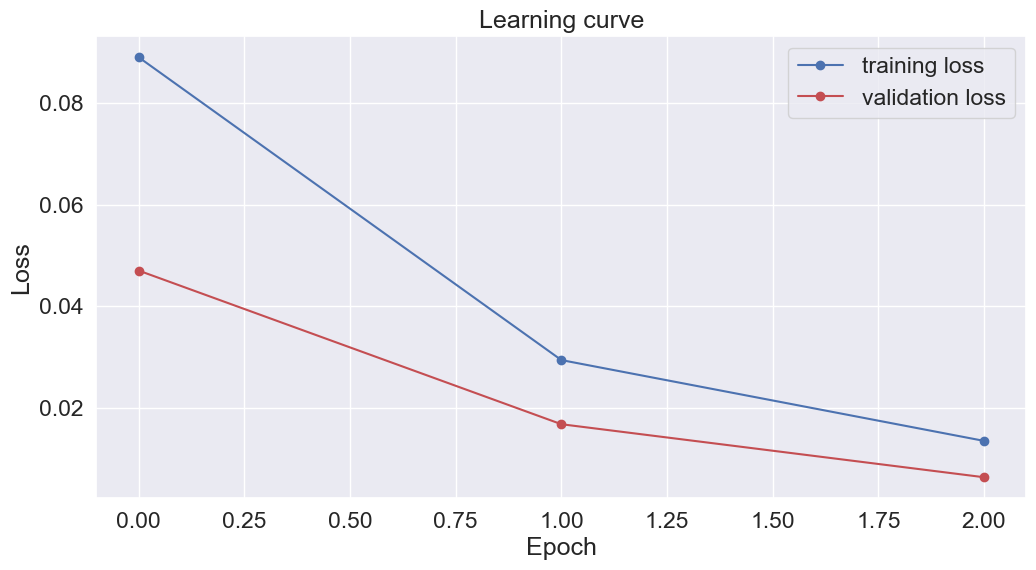

In [36]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(train_loss_values, 'b-o', label="training loss")
plt.plot(val_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Predictions on Test data

In [37]:
# Set the model into evaluation mode
model.eval()
test_loss, test_accuracy = 0, 0
predictions , true_labels = [], []
for batch in test_dataloader:
    optim.zero_grad()
    outputs = model(batch[0], attention_mask=batch[1], labels=batch[2])
    loss = outputs[0]
    test_loss += loss.mean().item()
    logits = outputs.logits
    optim.step()

    label_ids = batch[2].to(device).numpy()
    predictions.extend(np.argmax(torch.sigmoid(outputs.logits).detach().numpy(),2))
    true_labels.extend(label_ids)

test_loss = test_loss / len(test_dataloader)
print("Average Test loss: {}".format(test_loss))
auroc = AUROC(task="binary")
print("Test AUROC = {}".format(auroc(torch.tensor(predictions), torch.tensor(true_labels))))

/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(self.encodings["input_ids"][idx]).squeeze()
/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.encodings["attention_mask"][idx]).squeeze()


Average Test loss: 0.09663510799380336
Test AUROC = 0.9176534414291382


### Testing out a random sentence

In [40]:
test_sentence = """
The patient presents with a history of diabetes mellitus hyperlipidemia and hypertension complaining of shortness of breath and chest pain
"""

tokenized_sentence = tokenizer(test_sentence, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='pt',
                            #    return_offsets_mapping=True
                            )
tokenized_sentence

{'input_ids': tensor([[  101,  1996,  5776,  7534,  2007,  1037,  2381,  1997, 14671, 11463,
         15909,  2271, 23760, 15000,  5178, 10092,  1998, 23760, 29048, 17949,
          1997,  2460,  2791,  1997,  3052,  1998,  3108,  3255,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), 'atte

In [41]:
# input_ids = torch.tensor([tokenized_sentence])
with torch.no_grad():
    model.eval()
    output = model(input_ids=tokenized_sentence["input_ids"], 
                   attention_mask=tokenized_sentence["attention_mask"])
label_indices = np.argmax(torch.sigmoid(output.logits).detach().numpy(),2)
label_indices

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1]])

In [43]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence["input_ids"].to('cpu').numpy()[0])

In [44]:
counter =0 
for i in range(len(tokens)):
    if (tokens[i]=='[SEP]'):
        break
    print (tokens[i]," --> ", label_indices[0][counter])
    counter = counter+1

[CLS]  -->  0
the  -->  0
patient  -->  0
presents  -->  0
with  -->  0
a  -->  0
history  -->  0
of  -->  0
diabetes  -->  1
mel  -->  1
##lit  -->  1
##us  -->  1
hyper  -->  1
##lip  -->  1
##ide  -->  1
##mia  -->  1
and  -->  0
hyper  -->  1
##tension  -->  1
complaining  -->  0
of  -->  0
short  -->  1
##ness  -->  1
of  -->  1
breath  -->  1
and  -->  1
chest  -->  1
pain  -->  1


In [45]:
new_tokens= []
new_labels = []
for token, tag in zip(tokens, label_indices[0]):
    if (token =='[SEP]'):
        break
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
        new_labels[-1] = max(new_labels[-1], tag)
    else:
        new_tokens.append(token)
        new_labels.append(tag)


for token, tag in zip(new_tokens, new_labels):
    print (token," --> ", tag)

[CLS]  -->  0
the  -->  0
patient  -->  0
presents  -->  0
with  -->  0
a  -->  0
history  -->  0
of  -->  0
diabetes  -->  1
mellitus  -->  1
hyperlipidemia  -->  1
and  -->  0
hypertension  -->  1
complaining  -->  0
of  -->  0
shortness  -->  1
of  -->  1
breath  -->  1
and  -->  1
chest  -->  1
pain  -->  1


# NanoBERT

Training and finetuning the pretrained NanoBertForTokenClassification model

In [23]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

base_model = nano.NanoBert(nano.NanoBertConfig())
base_model.load_state_dict(torch.load("./NanoBERT/nanobert/weights1.pt"))
nano_bert_model = nano.NanoBertForTokenClassification(base_model, out_features=MAX_LEN).to(device)
nano_bert_model.to(device)

# Optimizer
optim = AdamW(nano_bert_model.parameters(), lr=5e-5)
token_type_ids = torch.tensor(np.zeros(MAX_LEN)).to(torch.int64)

/Users/vidyabulusu/deeplearning/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
%%time

model = nano_bert_model
train_loss_values, val_loss_values = [], []

for epoch in range(10):
    print('--------------------------------------------------------------------------')
    print(f'Epoch: {epoch}')
    model.train()
    total_loss = 0
    total_val_loss = 0
    for batch in train_dataloader:
        optim.zero_grad()
        outputs = model(batch[0], attention_mask=batch[1], token_type_ids=token_type_ids)
        loss = None
        labels = batch[2]
        if labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-100)
            if batch[1] is not None:
                active_loss = batch[1].view(-1) == 1
                active_logits = outputs.logits.view(-1, MAX_LEN)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(outputs.logits.view(-1, MAX_LEN), labels.view(-1))
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optim.step()
    
    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store each loss value for plotting the learning curve afterwards
    train_loss_values.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy = 0, 0
    predictions , true_labels = [], []

    for batch in val_dataloader:
        optim.zero_grad()
        outputs = model(batch[0], attention_mask=batch[1], token_type_ids=token_type_ids)
        # val_loss = torch.nn.functional.cross_entropy(outputs.logits.view(-1, outputs.logits.shape[-1]), batch[2].view(-1), reduction='mean', ignore_index=-100)
        val_loss = None
        labels = batch[2]
        if labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-100)
            if batch[1] is not None:
                active_loss = batch[1].view(-1) == 1
                active_logits = outputs.logits.view(-1, MAX_LEN)
                active_labels = torch.where(
                    active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                )
                val_loss = loss_fct(active_logits, active_labels)
            else:
                val_loss = loss_fct(outputs.logits.view(-1, MAX_LEN), labels.view(-1))
        val_loss.backward()
        total_val_loss += val_loss.item()

        label_ids = batch[2].to(device).numpy()
        label_ids[label_ids == -1] = 0
        predictions.extend(np.argmax(torch.sigmoid(outputs.logits).detach().numpy(),2))
        true_labels.extend(label_ids)

        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optim.step()

    eval_loss = total_val_loss / len(val_dataloader)
    val_loss_values.append(eval_loss)
    print("Average Validation loss: {}".format(eval_loss))
    auroc = AUROC(task="binary")
    print("Validation AUROC: {}".format(auroc(torch.tensor(predictions), torch.tensor(true_labels))))
    print()

--------------------------------------------------------------------------
Epoch: 0


/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(self.encodings["input_ids"][idx]).squeeze()
/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.encodings["attention_mask"][idx]).squeeze()


Average train loss: 2.2222707439871394
Average Validation loss: 0.6584718098928188
Validation AUROC: 0.5

--------------------------------------------------------------------------
Epoch: 1


<timed exec>:74: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)


Average train loss: 0.4657478180001764
Average Validation loss: 0.3464811660092452
Validation AUROC: 0.5044569969177246

--------------------------------------------------------------------------
Epoch: 2
Average train loss: 0.3201586440643843
Average Validation loss: 0.27845208167002117
Validation AUROC: 0.5900686383247375

--------------------------------------------------------------------------
Epoch: 3
Average train loss: 0.2677693942890448
Average Validation loss: 0.24232558957461653
Validation AUROC: 0.6627005338668823

--------------------------------------------------------------------------
Epoch: 4
Average train loss: 0.23739189332460656
Average Validation loss: 0.21602750364048728
Validation AUROC: 0.7210975885391235

--------------------------------------------------------------------------
Epoch: 5
Average train loss: 0.21508779444676987
Average Validation loss: 0.1958036814527265
Validation AUROC: 0.7519999146461487

------------------------------------------------------

### Train and validation Loss curves

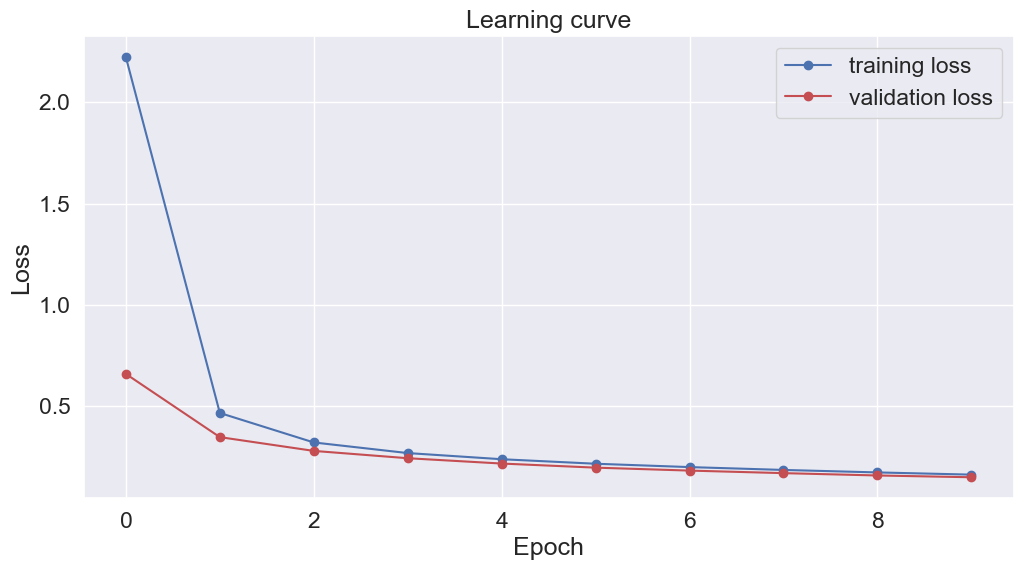

In [25]:
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(train_loss_values, 'b-o', label="training loss")
plt.plot(val_loss_values, 'r-o', label="validation loss")

plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Predictions on Test Data

In [26]:
model.eval()
test_loss, test_accuracy = 0, 0
predictions , true_labels = [], []
for batch in test_dataloader:
    optim.zero_grad()
    outputs = model(batch[0],attention_mask=batch[1],token_type_ids=token_type_ids)
    logits = outputs.logits
    optim.step()

    label_ids = batch[2].to(device).numpy()
    predictions.extend(np.argmax(torch.sigmoid(outputs.logits).detach().numpy(), 2))
    true_labels.extend(label_ids)

auroc = AUROC(task="binary")
print("Test AUROC = {}".format(auroc(torch.tensor(predictions), torch.tensor(true_labels))))

/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(self.encodings["input_ids"][idx]).squeeze()
/var/folders/8f/gqbjf14j72jb6646l_px2fcr0000gn/T/ipykernel_5939/61078976.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids = torch.tensor(self.encodings["attention_mask"][idx]).squeeze()


Test AUROC = 0.8278783559799194


### Testing a random sentence

In [28]:
test_sentence = """
The patient presents with a history of diabetes mellitus hyperlipidemia and hypertension complaining of shortness of breath and chest pain
"""
# test_sentence = 'hyperlipidemia'

tokenized_sentence = tokenizer(test_sentence, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='pt',
                            #    return_offsets_mapping=True
                            )
tokenized_sentence

{'input_ids': tensor([[  101,  1996,  5776,  7534,  2007,  1037,  2381,  1997, 14671, 11463,
         15909,  2271, 23760, 15000,  5178, 10092,  1998, 23760, 29048, 17949,
          1997,  2460,  2791,  1997,  3052,  1998,  3108,  3255,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), 'atte

In [29]:
# input_ids = torch.tensor([tokenized_sentence])
with torch.no_grad():
    model.eval()
    output = model(input_ids=tokenized_sentence["input_ids"], 
                   attention_mask=tokenized_sentence["attention_mask"], 
                   token_type_ids=token_type_ids)
label_indices = np.argmax(torch.sigmoid(output.logits).detach().numpy(),2)
label_indices

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [30]:
tokens = tokenizer.convert_ids_to_tokens(tokenized_sentence["input_ids"].to('cpu').numpy()[0])
# tokens

In [31]:
counter =0 
for i in range(len(tokens)):
    if (tokens[i]=='[SEP]'):
        break
    # print (tokens[i]," --> ", label_indices[0][counter])
    counter = counter+1

In [32]:
new_tokens= []
new_labels = []
for token, tag in zip(tokens, label_indices[0]):
    if (token =='[SEP]'):
        break
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
        new_labels[-1] = max(new_labels[-1], tag)
    else:
        new_tokens.append(token)
        new_labels.append(tag)


for token, tag in zip(new_tokens, new_labels):
    print (token," --> ", tag)

[CLS]  -->  0
the  -->  0
patient  -->  0
presents  -->  0
with  -->  0
a  -->  0
history  -->  0
of  -->  0
diabetes  -->  0
mellitus  -->  1
hyperlipidemia  -->  1
and  -->  0
hypertension  -->  1
complaining  -->  0
of  -->  0
shortness  -->  0
of  -->  0
breath  -->  1
and  -->  0
chest  -->  0
pain  -->  0
